In [19]:
import torch

from models.predictionnet import ResBlock, UpSample, DownSample, AttentionBlock, DownBlock, UpBlock, MidBlock, PadBlock, UnPadBlock, UNet, DummyModel, PredictionModel
from models.autoencoder import Autoencoder
from data.latents import LatentsDataModule
from models.blocks.distributions import DiagonalGaussianDistribution

from matplotlib import pyplot as plt

import xarray as xr
import numpy as np
import dask.array as da
import pandas as pd
import xbatcher as xb
import time
from tqdm import tqdm
from multiprocessing.dummy import Pool as ThreadPool
import yaml
import os

In [2]:
data_module = LatentsDataModule(batch_size=1)

data_loader = data_module.val_dataloader()

In [3]:
sample_1 = next(iter(data_loader))

In [4]:
x_1, y_1 = sample_1

zeros = torch.zeros_like(x_1)
ones = torch.ones_like(x_1)
noise = torch.randn_like(x_1)

mse = torch.nn.MSELoss()

print("MSE between x_1 and x_1: ", mse(x_1, x_1).item())

print("MSE between x_1 and y_1: ", mse(x_1, y_1).item())

print("MSE between x_1 and zeros: ", mse(x_1, zeros).item())
print("MSE between y_1 and zeros: ", mse(y_1, zeros).item())

print("MSE between x_1 and ones: ", mse(x_1, ones).item())
print("MSE between y_1 and ones: ", mse(y_1, ones).item())

print("MSE between x_1 and noise: ", mse(x_1, noise).item())
print("MSE between y_1 and noise: ", mse(y_1, noise).item())

MSE between x_1 and x_1:  0.0
MSE between x_1 and y_1:  1.956796646118164
MSE between x_1 and zeros:  0.9998250603675842
MSE between y_1 and zeros:  0.998812735080719
MSE between x_1 and ones:  2.010244846343994
MSE between y_1 and ones:  2.005682945251465
MSE between x_1 and noise:  1.9999470710754395
MSE between y_1 and noise:  2.0027897357940674


In [5]:
# model = DummyModel.load_from_checkpoint("checkpoints/dummy_model.ckpt")
model = PredictionModel.load_from_checkpoint("checkpoints/prediction_model.ckpt").to("cpu")
model.eval()

with torch.no_grad():
    pred_1 = model(x_1)

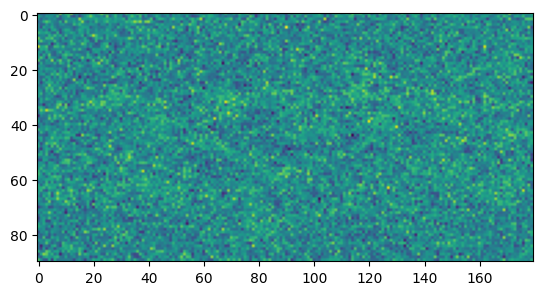

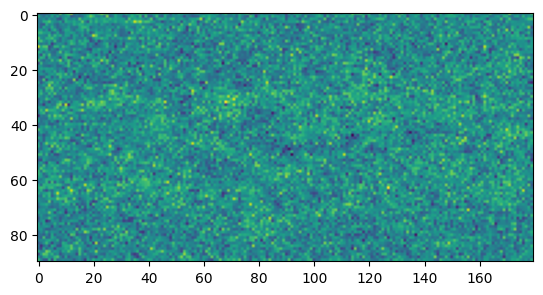

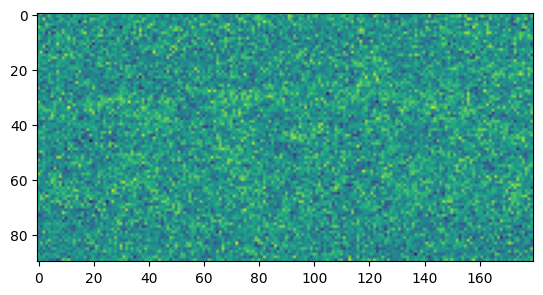

MSE between x_1 and y_1:  1.956796646118164
MSE between x_1 and pred_1:  0.3161616325378418
MSE between pred_1 and y_1:  1.3456782102584839


In [6]:
feature = 0

plt.imshow(x_1[0, feature].numpy().T)
plt.show()

plt.imshow(pred_1[0, feature].numpy().T)
plt.show()

plt.imshow(y_1[0, feature].numpy().T)
plt.show()

print("MSE between x_1 and y_1: ", mse(x_1, y_1).item())
print("MSE between x_1 and pred_1: ", mse(x_1, pred_1).item())
print("MSE between pred_1 and y_1: ", mse(pred_1, y_1).item())

In [38]:
with open("configs/autoencoder/kl-f8.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

device = "cpu"

model : Autoencoder = Autoencoder.load_from_checkpoint(
    "checkpoints/vae-kl-f8-rmse-disc-2-step=5000-z500=93.ckpt", config=config, strict=False).to("cuda")

model.eval()

c:\Users\hendr\Desktop\3d-vae\venv\Lib\site-packages\lightning\pytorch\utilities\migration\utils.py:56: The loaded checkpoint was produced with Lightning v2.5.1, which is newer than your current Lightning version: v2.5.0.post0


Autoencoder(
  (encoder): Encoder(
    (conv_in): Conv2d(69, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownBlock(
        (layers): ModuleList(
          (0): Sequential(
            (0): GroupNorm(32, 128, eps=1e-05, affine=True)
            (1): SiLU()
            (2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (3): GroupNorm(32, 256, eps=1e-05, affine=True)
            (4): SiLU()
            (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (1): Sequential(
            (0): GroupNorm(32, 256, eps=1e-05, affine=True)
            (1): SiLU()
            (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (3): GroupNorm(32, 256, eps=1e-05, affine=True)
            (4): SiLU()
            (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
        (residual_input_conv): Modul

In [10]:
with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
    with torch.no_grad():
        x_1_cuda = x_1.to("cuda")
        y_1_cuda = y_1.to("cuda")
        pred_1_cuda = pred_1.to("cuda")

        decoded_sample = model.decode(x_1_cuda)
        decoded_real = model.decode(y_1_cuda)
        decoded_pred = model.decode(pred_1_cuda)

        decoded_sample = decoded_sample.detach().cpu().type(torch.float32)
        decoded_real = decoded_real.detach().cpu().type(torch.float32)
        decoded_pred = decoded_pred.detach().cpu().type(torch.float32)

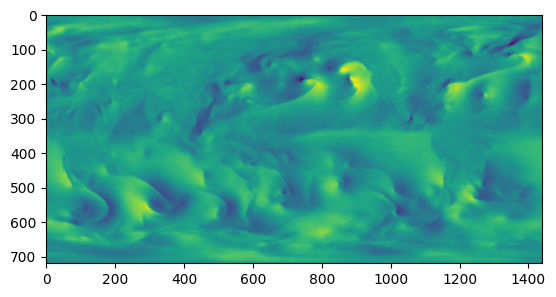

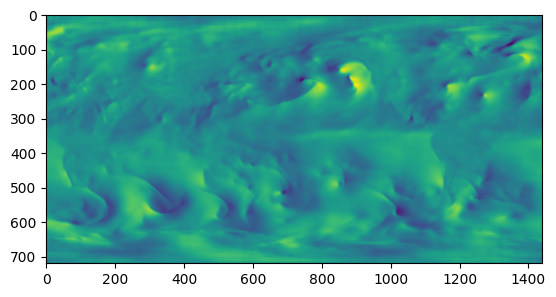

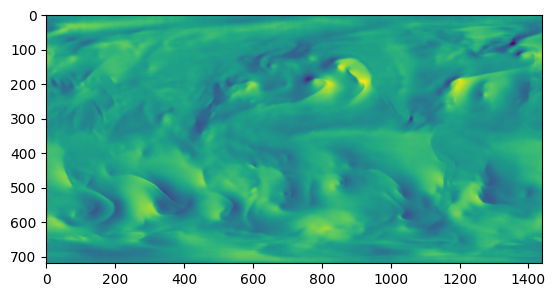

In [14]:
plt.imshow(decoded_sample[0, 2].numpy().T)
plt.show()

plt.imshow(decoded_pred[0, 2].numpy().T)
plt.show()

plt.imshow(decoded_real[0, 2].numpy().T)
plt.show()

In [10]:
print(x_1.mean())
print(x_1.std())

print(y_1.mean())
print(y_1.std())

tensor(-0.0052)
tensor(0.9999)
tensor(-0.0034)
tensor(0.9994)


In [23]:
x = torch.randn(1, 64, 128, 128)
y = torch.randn(1, 64, 128, 128)

print("MSE between x and y: ", mse(x, y).item())

MSE between x and y:  1.9996120929718018


In [4]:
ds = xr.open_zarr("zarr_files/latent_moments_vae-kl-f8.zarr/", consolidated=False)

In [5]:
ds

<xarray.Dataset> Size: 66MB
Dimensions:  (channel: 128, time: 16, x: 180, y: 90)
Coordinates:
  * channel  (channel) int64 1kB 0 1 2 3 4 5 6 7 ... 121 122 123 124 125 126 127
  * time     (time) datetime64[ns] 128B 2023-01-01 ... 2023-01-04T18:00:00
  * x        (x) int64 1kB 0 1 2 3 4 5 6 7 8 ... 172 173 174 175 176 177 178 179
  * y        (y) int64 720B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
Data variables:
    data     (time, channel, x, y) float16 66MB dask.array<chunksize=(1, 128, 180, 90), meta=np.ndarray>

In [35]:
item = ds.isel(time=0).data.compute()
item = item.to_numpy()
type(item)

numpy.ndarray

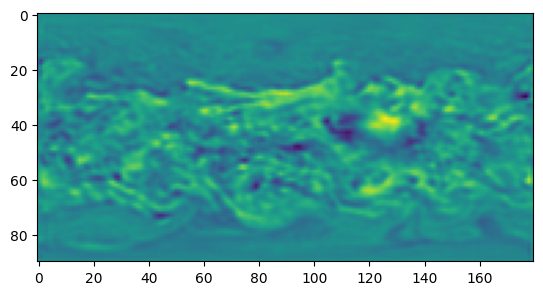

In [36]:
plt.imshow(item[0].T)
plt.show()

In [40]:
with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
    with torch.no_grad():
        item_cuda = torch.from_numpy(item).to("cuda").unsqueeze(0)

        posterior = DiagonalGaussianDistribution(item_cuda)
        sample = posterior.sample()
        dec = model.decode(sample)
        dec = dec.detach().cpu().type(torch.float32)
        dec = dec.numpy()

dec.shape

(1, 69, 1440, 720)

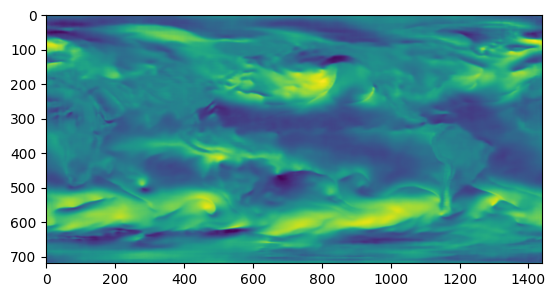

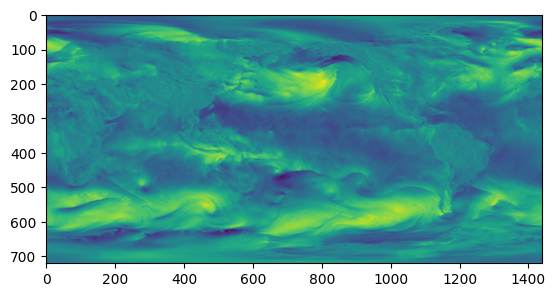

In [57]:
plt.imshow(dec[0, 1].T)
plt.show()

ds = xr.open_zarr('gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',
                      chunks=None, storage_options=dict(token='anon'),)
item = ds["10m_u_component_of_wind"].sel(time="2023-01-01T00:00:00").data

plt.imshow(item)
plt.show()